In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sb
from underlying import Underlying
from option import Option, Vanilla
from trader import Trader
from tqdm import tqdm
from quantile_hedging_calculator import *

## 2) 

## Wyprowadzenie hedgingu kwantylowego (dla handlowalnego aktywa bazowego)

Wyprowadźmy teraz teorię stojącą za hedgingiem kwantylowym, skupiąc się na pierwszej funkcji celu

$$\phi = \mathbb{1}_{\{H \leq V_{T} \}},$$

a więc sytuacji, w której chcielibyśmy, aby nasz ograniczony kapitał przekazany na hedging zabezpieczał nas dokładnie z jak największym prawdopodobieństwem. Aby to przedstawić formalniej oznaczmy

$$A = {\{H \leq V_{T} \}}$$

i naszym celem jest znalezienie zbioru $A$ maksymalizującego prawdopodobieństwo 

$$P \left[ A \right],$$

przy założeniu, ze początkowy kapitał $V_{0}$ spełnia $V_{0} < H_{0}$ (gdzie $H_{0}$ oznacza cenę Blacka-Scholesa zabezpieczanej opcji), oraz znalezienie strategii, którą mamy się kierować, aby cel ten osiągnąć.

#### Twierdzenie:
Jeśli $Q$ oznacza jedyną miarę martyngałową i wprowadzimy miarę $Q^{*}$, zadaną przez pochodną Radona-Nikodyma:

$$\frac{dQ^{*}}{dQ} = \frac{H}{H_{0}}$$

(gdzie H jest zmienną losową określającą payoff zabezpieczanej opcji) to zbiorem $\tilde{A}$ maksymalizującym powyższe prawdopodobieństwo jest

$$\tilde{A} = \Big{\{} \frac{dP}{dQ} > \tilde{a} \cdot H \Big{\}},$$

dla

$$\tilde{a} = inf \Big{\{} a: Q^{*} \left( \frac{dP}{dQ} > a \cdot H \right) \leq \alpha \Big{\}},$$

spełniający

$$Q^{*}(\tilde{A}) = \alpha := \frac{V_{0}}{H_{0}},$$

a optymalną strategią jest idealny delta hedging opcji o payoffie $\tilde{H} = H \cdot \mathbb{1}_{\tilde{A}}$.

Zamiast przepisywać dowód z pracy Petera Leukerta i Hansa Folmera, skupimy się na obrazowym wyjaśnieniu powyższej teorii i pokazaniu jak w praktyce znaleźć zbiór $\tilde{A}$ oraz poszukiwaną strategię.  

### Szukanie zbioru $\tilde{A}$

Zgodnie z powyższym, musimy znaleźć zbiór

$$\tilde{A} = \Big{\{} \frac{dP}{dQ} > \tilde{a} \cdot H \Big{\}}$$

Wiemy, że w przypadku modelowania zachowania aktywa geometrycznym ruchem Browna, pochodna Radona-Nikodyma ma postać

$$ \frac{d Q}{d P} =  e^{- \lambda W_{t} - \frac{1}{2} \lambda^{2}t}$$

dla $\lambda = \frac{\mu - r}{\sigma}$, tak więc występująca w naszym zbiorze odwrotność wynosi

$$ \frac{d P}{d Q} =  e^{\lambda W_{t} + \frac{1}{2} \lambda^{2}t}.$$

Skupimy się teraz na przypadku klasycznej opcji call, o cenie wykonania $K$, co daje nam payoff

$$H = \left( S_{T} - K \right)_{+}$$. Zbiór $\tilde{A}$ jest więc trajektorii spełniających nierówność

$$e^{\lambda W_{t} + \frac{1}{2} \lambda^{2}t} > \tilde{a} \cdot \left( S_{T} - K \right)_{+},$$

co po rozpisaniu wzoru $S_{T}$ daje

$$ e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} > \tilde{a} \cdot \left( e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - K \right)_{+}.$$

Obrazowo, mamy w tej chwili (z perspektywy $W_{T}$) dwie funkcje wykładnicze i jedyny nierozpisany jeszcze parametr $\tilde{a}$, będzie służył do przemnożenia prawej strony, ale zbiór rozwiązań nierówności miał miarę $\alpha$. Po chwili zastanowienia jednak, zauważamy, że są dwa przypadki, wynikające ze współczynników przy $W_T$. Przedstawmy to na wykresie:

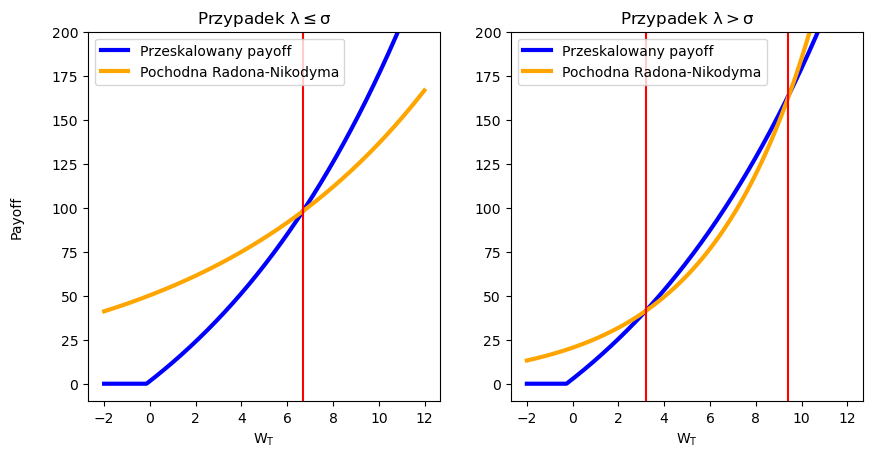

In [50]:
mu = 0.02
sigma = 0.1
r = 0.01
T = 1
X0 = 100
K = 110
p = 0.8
l = (mu-r)/sigma

WT = np.arange(-2,12,0.01)
ST = X0*np.exp((mu-sigma**2/2)*T+sigma*WT)
X = np.zeros(shape=(len(ST),2))
X[:,0], X[:,1] = X0, ST
X = pd.DataFrame(X)
dP_dQ = np.exp(l*WT+0.5*l**2*T)
K = 100

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

ax1.set_xlabel('$\mathregular{W_T}$')
ax1.set_ylabel('Payoff', labelpad=20)
ax2.set_xlabel('$\mathregular{W_T}$')
#ax2.set_ylabel('Payoff', labelpad=20)

# Payoff klasycznej funkcji call
ax1.plot(WT,np.array((X.iloc[:,-1] - K) * (X.iloc[:,-1] > K)), color = 'blue', linewidth = 3, label = 'Przeskalowany payoff' )
ax1.plot(WT, X0*dP_dQ/2, color = 'orange', linewidth = 3, label = 'Pochodna Radona-Nikodyma')
ax1.set_ylim(top=max(X0*dP_dQ)+2)
ax1.set_title('Przypadek $\mathregular{\lambda \leq \sigma}$')
ax1.set_ylim(bottom=-10,top=200)
#wybacz kreski od ręki xd
ax1.axvline(x=6.7, color='red')
ax1.legend(loc="upper left")

mu_2 = 0.032
l_2 = (mu_2-r)/sigma
WT_2 = np.arange(-2,12,0.01)
ST_2 = X0*np.exp((mu_2-sigma**2/2)*T+sigma*WT)
X_2 = np.zeros(shape=(len(ST_2),2))
X_2[:,0], X_2[:,1] = X0, ST_2
X_2 = pd.DataFrame(X_2)
dP_dQ_2 = np.exp(l_2*WT_2+0.5*l_2**2*T)

# Payoff procentowej opcji call
ax2.plot(WT_2,np.array((X_2.iloc[:,-1] - K) * (X_2.iloc[:,-1] > K)), color = 'blue', linewidth = 3, label = 'Przeskalowany payoff')
ax2.plot(WT_2, X0*dP_dQ_2/5, color = 'orange', linewidth = 3, label = 'Pochodna Radona-Nikodyma')
ax2.set_title('Przypadek $\mathregular{\lambda > \sigma}$')
ax2.set_ylim(bottom=-10,top=200)
ax2.axvline(x=3.2, color='red')
ax2.axvline(x=9.4, color='red')
ax2.legend(loc="upper left")

plt.show()

Otrzymujemy więc przypadki $\lambda \leq \sigma$ i $\lambda > \sigma$, które rozpiszemy.

W pierwszy przypadku, nierówność jest spełniona dla $W_{T}$ mniejszych niż punkt przecięcia widoczny na lewym wykresie (nazwijmy go $w_{0}$). Finalnie jednak będzie nas interesowało jaka cena aktywa wynika z takiej wartości (aby nałożyć indykator na payoff opcji), tak więc od razu możemy podejść do zagadnienia przez pryzmat ceny aktywa. Ponadto, widząc już, że otrzymamy w tym przypadku rezultat postaci $\tilde{A} = \Big{\{} W_{T} < w_{0} \Big{\}} = \Big{\{} S_{T} < c \Big{\}}$ (gdzie c to cena wynikajaca z wartości $w_{0}$) możemy oderwać się od rozwiązywania nierówności i spojrzeć dalej. Mianowicie, wiemy, że $c$ musi być dobrane tak, by cena opcji o payoffie o zerowych wartościach powyżej $c$, miała cenę $V_{0}$. Dzięki temu możemy iteracyjnie podejść do zagadnienia następująco:

1) Generujemy trajektorie $W_{T}$ i sortujemy:

$$W_{T} = \left[ -2.782, -2.23, ... ,-0.56, 0.124, ... , 2.857 \right]$$

2) Przekładamy je na ceny $S_{T}$

$$S_{T} = \left[ 58.39, 62.34, ... , 91.15, 103.14, ... , 183.73 \right]$$

3) Chcemy $Q^{*}(\tilde{A}) = \alpha$, a skoro $Q^{*}(\tilde{A}) = \mathbb{E}_{Q} \left[ \frac{dQ^{*}}{dQ} \cdot \mathbb{1}_{\tilde{A}} \right] = \mathbb{E} \left[ \frac{dQ}{dP} \cdot \frac{dQ^{*}}{dQ} \cdot \mathbb{1}_{\tilde{A}} \right]$, to likczymy najpierw pełen wektor $\frac{dQ}{dP} \cdot \frac{dQ^{*}}{dQ} (= \frac{dQ^{*}}{dP})$ zgodnie ze wzorami wyprowadzonymi wcześniej, podstawiając powyższe symulacje i payoff opcji call pod $H$:
$$\frac{dQ^{*}}{dP} = \left[ 0 , 0, ... , 0, 0.001, 0.003, ..., 4.75\right]$$

4) Iterujemy po liczbach $c$ od ostatniej ceny $S_{T}$, co skutkuje zerowaniem wartości $S_{T} > c$ oraz odpowiadających im wartości w wektorze $\frac{dQ^{*}}{dP}$, licząc przy tym $\mathbb{E} \left[ \frac{dQ}{dP} \cdot \frac{dQ^{*}}{dQ} \cdot \mathbb{1}_{\tilde{A}} \right]$, aż znajdziemy takie, które daje $\mathbb{E} \left[ \frac{dQ}{dP} \cdot \frac{dQ^{*}}{dQ} \cdot \mathbb{1}_{\tilde{A}} \right] = \alpha$. 

5) Ponieważ symulacje same z siebie wychodzą się zgodnie z rozkładem normalnym, to liczenie $\mathbb{E} \left[ \frac{dQ}{dP} \cdot \frac{dQ^{*}}{dQ} \cdot \mathbb{1}_{\tilde{A}} \right]$ odbywa się poprzez sumowanie $\frac{dQ^{*}}{dP} \cdot \mathbb{1}_{ \{ S_{T} < c \} } \cdot \frac{1}{n}$, gdzie $n$ oznacza liczbę symulacji i reprezentuje wagi (rozkłozone jednostajnie) z wartości oczekiwanej

Koniec, znaliźliśmy poszukiwane $c$ i mamy teraz "obciety" payoff naszej wyjściowej opcji call. Strategia hedgingu polega na idealnym hedgowaniu opcji, mającej włąśnie ten ocięty payoff. 

Przypadek drugi jest bardzo adekwatny. Różnica polega na tym, ze będziemy mieli dwa przedziały:
$$\tilde{A} = \Big{\{} S_{T} < c_{1} \Big{\}} \cup \Big{\{} S_{T} > c_{2} \Big{\}}$$
i do rozwiazania podchodzimy tymi samymi krokami, z tą różnicą, ze camiast iterować jednym c, to iterujemy za pomocą $c_{1}$ i $c_{2}$, by zerować wartości między nimi, zachowując jednak zasadzę, że zostawione niezerowe wartości mają takie same wagi (czyli sumy wartośći z $\frac{dQ^{*}}{dP}$, dla wartości odpowiadajacych $S_{T} < c_{1}$ i $S_{T} > c_{2}$ sa takie same.

Na koniec przedstawmy jak koncepcyjnie wyglądają payoffy opcji, które chcemy zabezpieczać:

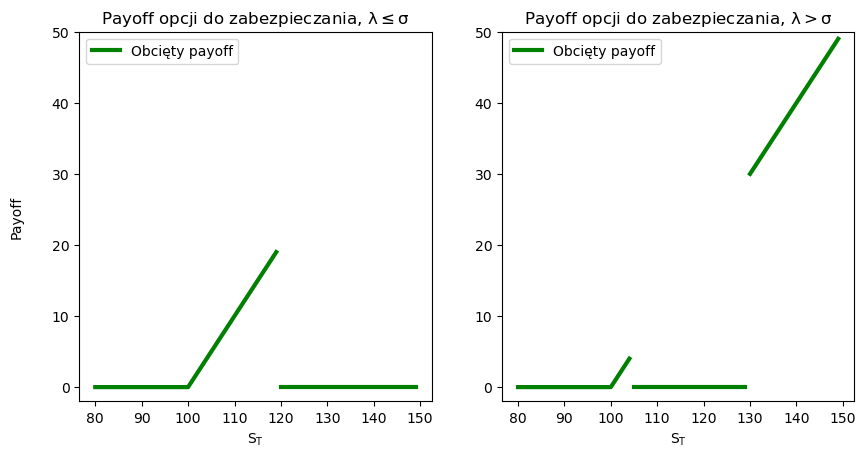

In [58]:
ST_1 = np.arange(80,120,1)
ST_2 = np.arange(120,150,1)
K = 100

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

ax1.set_xlabel('$\mathregular{S_T}$')
ax1.set_ylabel('Payoff', labelpad=20)
ax2.set_xlabel('$\mathregular{S_T}$')
#ax2.set_ylabel('Payoff', labelpad=20)

# Payoff klasycznej funkcji call
ax1.plot(ST_1,(ST_1 - K) * (ST_1 > K), color = 'green', linewidth = 3, label = 'Obcięty payoff')
ax1.plot(ST_2,np.zeros(len(ST_2)) , linewidth = 3, color = 'green')
ax1.set_title('Payoff opcji do zabezpieczania, $\mathregular{\lambda \leq \sigma}$')
ax1.set_ylim(bottom=-2,top=50)
ax1.legend(loc="upper left")

ST_3 = np.arange(80,105,1)
ST_4 = np.arange(105,130,1)
ST_5 = np.arange(130,150,1)

# Payoff procentowej opcji call
ax2.plot(ST_3,(ST_3 - K) * (ST_3 > K), color = 'green', linewidth = 3, label = 'Obcięty payoff')
ax2.plot(ST_4,np.zeros(len(ST_4)) , color='green', linewidth = 3)
ax2.plot(ST_5,ST_5 - K , color='green', linewidth = 3)
ax2.set_title('Payoff opcji do zabezpieczania, $\mathregular{\lambda > \sigma}$')
ax2.set_ylim(bottom=-2,top=50)
ax2.legend(loc="upper left")

plt.show()

## 4)

### Druga Funkcja Celu

Rozpatrzymy teraz drugą funkcję celu

$$ \phi = \mathbb{1}_{\{H \leq V_{T} \}} + \frac{V_{T}}{H} \mathbb{1}_{\{H > V_{T} \}}$$

i naszym celem ponownie będzie optymalizacja jej wartości oczekiwanej $ \left( \mathbb{E}\left[ \phi \right] \right) $.
Publikacja Hansa F \"{o} llmera i Petera Leukerta tym razem także dostarcza rozwiązanie, według którego strategią optymalizującą powyższą wartość jest pełny $\Delta$-hedging opcji o payoffie $\tilde{H} = \tilde{\phi}H$, dla

$$\tilde{\phi} = \mathbb{1}_{\{\frac{dP}{dQ} > \tilde{a} H \}} + \gamma \mathbb{1}_{\{\frac{dP}{dQ} = \tilde{a} H \}},$$
gdzie

$$\gamma = \frac{\alpha - Q^{*} \left[ \frac{dP}{dQ} > \tilde{a}H  \right]}{Q^{*} \left[ \frac{dP}{dQ} = \tilde{a}H  \right]}.$$

Pierwszy indykator funkcji $\tilde{\phi}$ pokrywa sytuacje z pierwszej funkcji celu, tak więc jedyną różnicą jest występowanie drugiego indykatora.

Teza:

W przypadku klasycznych opcji call i put oraz trajektorii modelowanych geometrycznym ruchem Browna, zbiór $\{\frac{dP}{dQ} = \tilde{a} H \}$ jest zbiorem miary zero.

Dowód:

Jak już wiemy

$$ \frac{d P}{d Q} =  e^{\lambda W_{t} + \frac{1}{2} \lambda^{2}t}.$$ 

Tym samym rozpatrujemy zbiór trajektorii spełniających równość

$$e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot H.$$

Korzystamy w tym miejscu z założenia, że rozpatrujemy opcję call (w przypadku opcji put argument jest analogiczny) i możemy rozpisać payoff $H$ jako:

$$H = \left( S_{T} - K \right)_{+}.$$

Następnie rozpisujemy jawnie wzór na $S_{T}$, co daje

$$H = \left( e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - K \right)_{+} $$

czym dochodzimy do poniższej postaci równości 

$$ e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot \left( e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - K \right)_{+}.$$

Zauważmy teraz, że możemy pominąć nałożoną po prawej stronie część dodatnią. Lewa strona równości jest funkcją wykładniczą, tak więc zawsze jest dodatnia i tym samym równość nie może zajść w przypadku gdy prawa strona jest zerowa lub ujemna, wobec czego pozwolenie ujemnym przypadkom pozostać ujemnym (zamiast zamieniania ich na 0), nie zmienia zbioru rozwiązań. Mamy tym samym

$$ e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot  \left( e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - K \right).$$

Rozpiszmy teraz $\lambda$

$$ e^{ \left( \frac{\mu - r}{\sigma} \right) W_{T} + \frac{1}{2} \left( \frac{\mu - r}{\sigma} \right)^{2}T} = \tilde{a} \cdot e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - \tilde{a} \cdot K$$

oraz dla przejrzystości wprowadźmy dwa oznaczenia

$$b_{1} = e^{\frac{1}{2} \left( \frac{\mu - r}{\sigma} \right)^{2}T}\ , \quad b_{2} = e^{\left( \mu - \frac{\sigma^{2}}{2} \right)T}$$

by ostatecznie otrzymać

$$ b_{1} \cdot e^{ \left( \frac{\mu - r}{\sigma} \right) W_{T}} = \tilde{a} \cdot b_{2} \cdot e^{\sigma W_{T}} - \tilde{a} \cdot K.$$

Są teraz trzy możliwe sytuacje:
1. Równanie jest sprzeczne i nie ma rozwiązań, co zadaje zbiór pusty (który jest oczywiście miary zero)

2. Równanie ma jedno lub dwa rozwiązania. Korzystamy teraz jednak z założenia o ciągłości, a mianowicie, ponieważ $W_{T}$ pochodzi z rozkładu normalnego, to dla każdego $x$ mamy $P \left [W_{T} = x \right] = 0 $, co również daje nam zbiór miary zero.

3. Potencjalnie interesowałaby nas więc jedynie ostatnia sytuacja  w której funkcje się (przynajmniej na pewnym przedziale) pokrywają, co zadałoby przedział o niezerowej mierze. Tak się jednak nie dzieje, ponieważ o ile może się zdarzyć, że części wykładnicze są takie same, o tyle prawa strona ma niezerowe przesunięcie. Uzasadnienie:

    Przesuniecie jest zadane przez $\tilde{a} K$. Jeśli $\tilde{a} = 0$, to cała prawa strona równa się $0$, co w obliczu dodatniości lewej strony daje sprzeczność. $K$ natomiast jest parametrem opcji call. Z założenia K > 0, ponieważ w przeciwnym przypadku nie mielibyśmy do czynienia z tym aktywem pochodnym (w przypadku K = 0 opcja dawałaby nam możliwość "zakupu" aktywa za darmo, niezależnie od scenariusza).
    
Co kończy dowód, że $\{\frac{dP}{dQ} = \tilde{a} H \}$ jest miary 0.

Wniosek:

Optymalizacja drugiej funkcji celu jest osiągana przez strategię, którą realizowaliśmy przy pierwszej funkcji celu.

## 5) 

## Druga funkcja celu z niezerową miarą drugiego indykatora

Naszym celem jest teraz wykreować sytuację, w której drugi indykator nie będzie bazował na zbiorze o zerowej mierze. Dążymy więc do tego, by zbiór

$$D = \Big{\{} \frac{dP}{dQ} = \tilde{a} H \Big{\}}$$

miał dodatnią miarę. Kluczowym momentem w poprzednim dowodzie było doprowadzenie powyższego zbioru do postaci

$$D = \Big{\{} e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot H \Big{\}},$$

a zerowość wynikała z payoffu klasycznej funkcji call, a konkretnie odejmowania współczynnika, którego nie można było wyzerować. Oznacza to, że aby osiagnąć cel musimy znaleźć opcję o innym payoffie, a powyższy dowodów sugeruje, że zapewne udałoby się dopasować w niej współczynniki jeśli jej payoff będzie miał charakter multiplikatywny. Wprowadzamy więc taką opcję, którą nazwyamy autorsko Procentową Opcją Call. Przedstawiamy jej działanie poniżej.

**Procentowa Opcja Call:** <br>
Posiadacz opcji zyskuje możliwość zakupu w chwili $T$ aktywa po cenie $p \cdot S_{T}$, jeśli cena przekroczy próg $K$ $(\text{dla }p \in (0,1))$. <br>

**Payoff:** $H = \left( S_{T} - p \cdot S_{T} \right) \cdot \mathbb{1}_{\{ S_{T} > K \}} = \left( 1 - p \right) \cdot S_{T}  \cdot \mathbb{1}_{\{ S_{T} > K \}}$

Spójrzmy jak on wygląda (na każdym kroku porównując do klasycznej opcji call):

In [2]:
mu = 0.02
sigma = 0.1
r = 0.01
T = 1
X0 = 100
K = 110
p = 0.8
l = (mu-r)/sigma
values_per_year = 250

def measure_payoff(X,p,K):
    return (1-p)*X.iloc[:, -1]*(X.iloc[:, -1] > K)

#Przedstawienie jak wyglada payoff tej funkcji z perspektywy S_T i porównanie do klasycznej
ST = np.arange(70,141,1)
X = np.zeros(shape=(len(ST),2))
X[:,0], X[:,1] = X0, ST
X = pd.DataFrame(X)

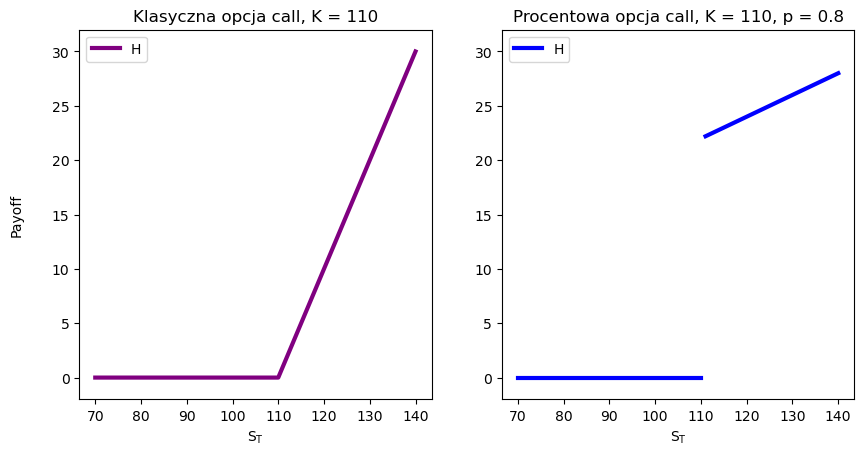

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

ax1.set_xlabel('$\mathregular{S_T}$')
ax1.set_ylabel('Payoff', labelpad=20)
ax2.set_xlabel('$\mathregular{S_T}$')

# Payoff klasycznej funkcji call
ax1.plot(ST,np.array((X.iloc[:,-1] - K) * (X.iloc[:,-1] > K)), color = 'purple', linewidth = 3, label='H')
ax1.set_ylim(top=max(max((X.iloc[:,-1] - K) * (X.iloc[:,-1] > K)),max(measure_payoff(X.iloc[ST>K,:],p,K)))+2)
ax1.set_ylim(bottom = -2)
ax1.set_title('Klasyczna opcja call, K = ' + str(K))
ax1.legend(loc="upper left")
ax1.set_xticks(np.arange(70,141,10))

# Payoff procentowej opcji call
ax2.plot(ST[ST<=K],np.array(measure_payoff(X.iloc[ST<=K,:],p,K)), color = 'blue', linewidth = 3, label='H')
ax2.plot(ST[ST>K],np.array(measure_payoff(X.iloc[ST>K,:],p,K)), color = 'blue', linewidth = 3)
ax2.set_ylim(top=max(max((X.iloc[:,-1] - K) * (X.iloc[:,-1] > K)),max(measure_payoff(X.iloc[ST>K,:],p,K)))+2)
ax2.set_ylim(bottom = -2)
ax2.set_title('Procentowa opcja call, K = ' + str(K) + ', p = ' +  str(p))
ax2.legend(loc="upper left")
ax2.set_xticks(np.arange(70,141,10))

plt.show()


Zobaczmy, że taka opcja rzeczywiście może spełniać powyższy warunek. Podstawiamy za $H$ policzony payoff i otrzymujemy

$$D = \Big{\{} e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot \left( 1 - p \right) \cdot S_{T} \cdot \mathbb{1}_{\{ S_{T} > K \}}  \Big{\}}$$

oraz po rozpisaniu $S_{T}$

$$D = \Big{\{} e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot \left( 1 - p \right) \cdot e^{\left(\mu - \frac{\sigma^{2}}{2}\right)T + \sigma W_{T}} \cdot \mathbb{1}_{\{ S_{T} > K \}}  \Big{\}}.$$

Intuicja za powyższym warunkiem $\left( D = \Big{\{} \frac{dP}{dQ} = \tilde{a} H \Big{\}} \right)$ jest następująca: chcemy przeskalować payoffu opcji, w sposób, który umożliwia jej pokrycie się z pochodną Radona-Nikodyma na pewnym przedziale (w tym przypadku $S_{T} < K$). Sytuację przed i po przeskalowanu możemy zaobserwowac na poniższych wykresach: (Uwaga! w literaturze patrzy się na ceny z perspektywy stosunku do wartości początkowej aktywa, tu jednak pozostaniemy przy wartościach nominalnych, tak więc pochodna Radona-Nikodyma została przemnożona przez cenę początkową wynoszącą 100)

In [48]:
WT = np.arange(-2,8,0.01)
ST = X0*np.exp((mu-sigma**2/2)*T+sigma*WT)
X = np.zeros(shape=(len(ST),2))
X[:,0], X[:,1] = X0, ST
X = pd.DataFrame(X)

#plt.plot(WT,np.array(a_wave*measure_payoff(X,p,1.1)))
#Radon-Nikodym
dP_dQ = np.exp(l*WT+0.5*l**2*T)

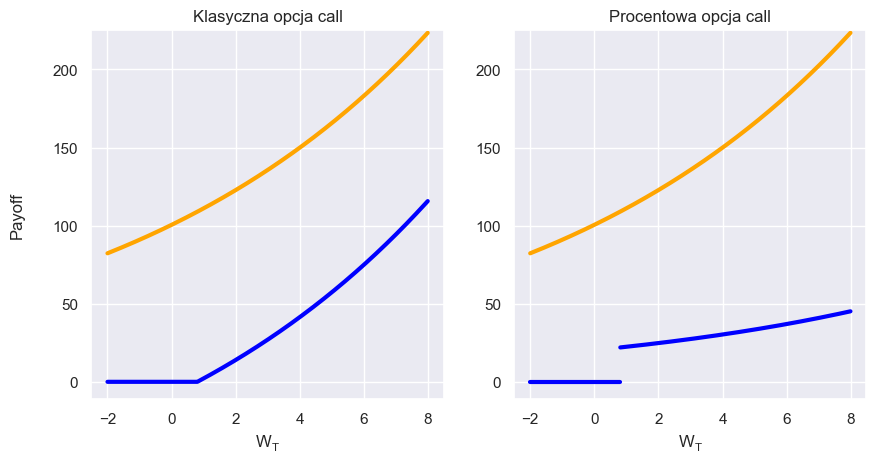

In [49]:
################
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

ax1.set_xlabel('$\mathregular{W_T}$')
ax1.set_ylabel('Payoff', labelpad=20)
ax2.set_xlabel('$\mathregular{W_T}$')
#ax2.set_ylabel('Payoff', labelpad=20)

# Payoff klasycznej funkcji call
ax1.plot(WT,np.array((X.iloc[:,-1] - K) * (X.iloc[:,-1] > K)), color = 'blue', linewidth = 3)
ax1.plot(WT, X0*dP_dQ, color = 'orange', linewidth = 3)
ax1.set_ylim(top=max(X0*dP_dQ)+2)
ax1.set_title('Klasyczna opcja call')

# Payoff procentowej opcji call
ax2.plot(WT[ST<=K],np.array(measure_payoff(X.iloc[ST<=K,:],p,K)), color = 'blue', linewidth = 3)
ax2.plot(WT[ST>K],np.array(measure_payoff(X.iloc[ST>K,:],p,K)), color = 'blue', linewidth = 3)
ax2.plot(WT, X0*dP_dQ, color = 'orange', linewidth = 3)
ax2.set_title('Procentowa opcja call')
ax2.set_ylim(top=max(X0*dP_dQ)+2)
plt.show()

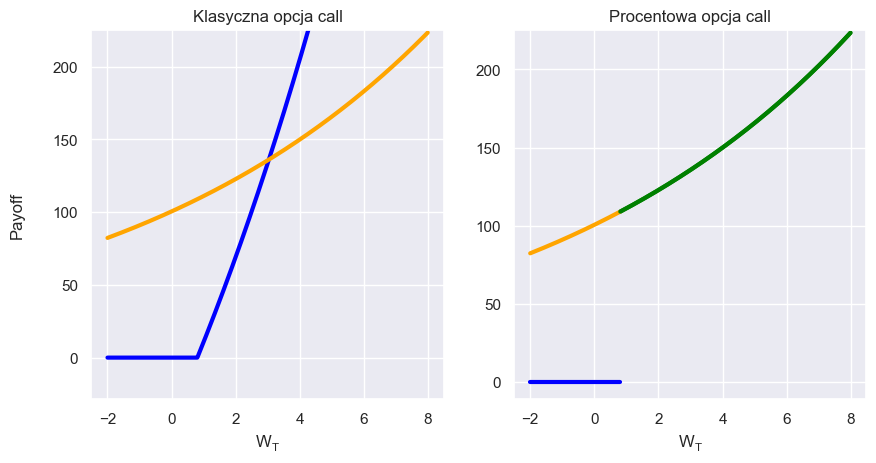

In [51]:
#Przeskalowane przez a_wave
a_wave = np.exp((sigma**2-mu)*T)/(1-p)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

ax1.set_xlabel('$\mathregular{W_T}$')
ax1.set_ylabel('Payoff', labelpad=20)
ax2.set_xlabel('$\mathregular{W_T}$')
#ax2.set_ylabel('Payoff', labelpad=20)

# Payoff klasycznej funkcji call
ax1.plot(WT,a_wave*np.array((X.iloc[:,-1] - K) * (X.iloc[:,-1] > K)), color = 'blue', linewidth = 3)
ax1.plot(WT, X0*dP_dQ, color = 'orange', linewidth = 3)
ax1.set_ylim(top=max(X0*dP_dQ)+2)
ax1.set_title('Klasyczna opcja call')
ax1.plot()

# Payoff procentowej opcji call
ax2.plot(WT[ST<=K],np.array(a_wave*measure_payoff(X.iloc[ST<=K,:],p,K)), color = 'blue', linewidth = 3)
ax2.plot(WT[ST>K],np.array(a_wave*measure_payoff(X.iloc[ST>K,:],p,K)), color = 'green', linewidth = 3)
ax2.plot(WT[ST<=K], X0*dP_dQ[ST<=K], color = 'orange', linewidth = 3)
ax2.plot(WT[ST>K], X0*dP_dQ[ST>K], color = 'green', linewidth = 3)
ax2.set_title('Procentowa opcja call')
ax2.set_ylim(top=max(X0*dP_dQ)+2)
plt.show()


Przejdźmy więc do konkretnego doboru parametrów. Ponieważ $W_{T}$ jest traktowany jako *zmienna* tych funkcji, to w celu zapewnienia równości (na przedziale $S_{T} > K$) musimy zapewnić równość współczynników przy $W_{T}$ oraz tych mnożących funkcję wykładniczą. równość współczynników $W_{T}$ daje kluczowy warunek:

$$\lambda = \sigma,$$

co po rozpisaniu $\lambda = \frac{\mu-r}{\sigma}$ daje

$$\mu - r = \sigma^{2}.$$

Możemy teraz skrócić cześci potęg związanych z $W_{T}$ oraz użyć powyższego warunku do podstawienia pod $\lambda$ i przenieść eksponens na jedną stronę, aby orzymać

$$D = \Big{\{} e^{\left(\sigma^{2} - \mu \right)T} = \tilde{a} \cdot \left( 1 - p \right) \cdot \mathbb{1}_{\{ S_{T} > K \}}  \Big{\}}.$$

Problematyczną kwestią zostaje wartość parametru $\tilde{a}$, ponieważ nie wiemy, czy nasz warunek spowodował, że powyżej rzeczywiście może zachodzi równość. Przyjrzyjmy się więc temu. Z definicji mamy

$$\tilde{a} = inf \Big{\{} a: Q^{*} \left( \frac{dP}{dQ} > a \cdot H \right) \leq \alpha \Big{\}},$$

podstawiamy $\frac{dP}{dQ}$ i $H$

$$\tilde{a} = inf \Big{\{} a: Q^{*} \left( e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} > a \cdot \left( 1 - p \right) \cdot S_{T} \cdot \mathbb{1}_{\{ S_{T} > K \}} \right) \leq \alpha \Big{\}},$$

ponownie rozpisujemy $S_{T}$

$$\tilde{a} = inf \Big{\{} a: Q^{*} \left( e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} > a \cdot \left( 1 - p \right) \cdot e^{\left(\mu - \frac{\sigma^{2}}{2}\right)T + \sigma W_{T}} \cdot \mathbb{1}_{\{ S_{T} > K \}} \right) \leq \alpha \Big{\}},$$

i korzystamy z warunku $\lambda = \sigma$ oraz grupujemy

$$\tilde{a} = inf \Big{\{} a: Q^{*} \left( e^{\left(\sigma^{2} - \mu \right)T} > a \cdot \left( 1 - p \right) \cdot \mathbb{1}_{\{ S_{T} > K \}} \right) \leq \alpha \Big{\}}$$

i ostatnie przekształcenie

$$\tilde{a} = inf \Big{\{} a: Q^{*} \left( \frac{e^{\left(\sigma^{2} - \mu \right)T}}{a \cdot \left( 1 - p \right)} > \mathbb{1}_{\{ S_{T} > K \}} \right) \leq \alpha \Big{\}}.$$

Wprowadźmy oznaczenie

$$l(a) := \frac{e^{\left(\sigma^{2} - \mu \right)T}}{a \cdot \left( 1 - p \right)}$$

Szukamy więc ograniczenia dolnego dla a, spośród tych, dla których miara rozwiązań nierówności

$$l(a) > \mathbb{1}_{\{ S_{T} > K \}}$$

w mierze $Q^{*}$ nie przekroczy $\alpha$ (które jest ostro mniejsze od 1).

Obrazowo:

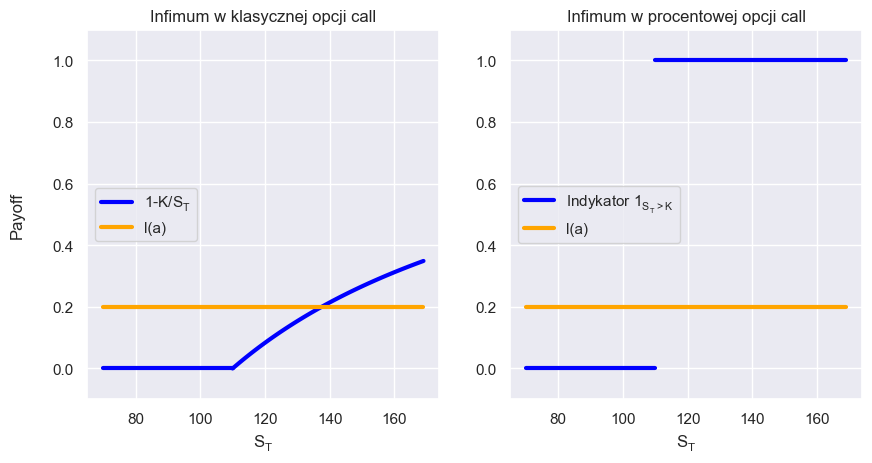

In [203]:
ST = np.arange(70,170,1)
K = 110

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

ax1.set_xlabel('$\mathregular{S_T}$')
ax1.set_ylabel('Payoff', labelpad=20)
ax2.set_xlabel('$\mathregular{S_T}$')
#ax2.set_ylabel('Payoff', labelpad=20)

# Infimum w klasycznej opcji call
ax1.plot(ST[ST<=K],np.zeros(len(ST[ST<=K])), color = 'blue', linewidth = 3, label = '1-K/$\mathregular{S_T}$')
ax1.plot(ST[ST>=K],1-K/ST[ST>=K], color = 'blue', linewidth = 3)
ax1.plot(ST,0.2*np.ones(len(ST)), color = 'orange', linewidth = 3, label='l(a)')
ax1.set_title('Infimum w klasycznej opcji call')
ax1.set_xlabel('$\mathregular{S_T}$')
ax1.set_ylim([-0.1,1.1])
ax1.legend(loc="center left")

# Infimum w klasycznej opcji call
ax2.plot(ST[ST<=K],np.zeros(len(ST[ST<=K])), color = 'blue', linewidth = 3, label='Indykator $\mathregular{1_{S_T > K}}$' )
ax2.plot(ST[ST>=K],np.ones(len(ST[ST>=K])), color = 'blue', linewidth = 3)
ax2.plot(ST,0.2*np.ones(len(ST)), color = 'orange', linewidth = 3, label='l(a)')
ax2.set_title('Infimum w procentowej opcji call')
ax2.set_xlabel('$\mathregular{S_T}$')
ax2.set_ylim([-0.1,1.1])
ax2.legend(loc="center left")
plt.show()

#plt.plot(ST[ST<=K],np.zeros(len(ST[ST<=K])), color = 'blue', linewidth = 3, label='Indykator')
#plt.plot(ST[ST>=K],np.ones(len(ST[ST>=K])), color = 'blue', linewidth = 3)
#plt.plot(ST,0.7*np.ones(len(ST)), color = 'orange', linewidth = 3, label='l(a)')
#plt.xlabel('$\mathregular{S_T}$')
#plt.ylabel('Wartość', labelpad=20)
#plt.title('Poszukiwanie infimum')
#plt.legend(loc="upper left")

Widzimy więc, ze mamy trzy przypadki:

1. Jeśli $l(a) < 0$ to $Q^{*} \left( l(a) > \mathbb{1}_{\{ S_{T} > K \}} \right) = 0$ 

2. Jeśli $l(a) \geq 1$ to $Q^{*} \left( l(a) > \mathbb{1}_{\{ S_{T} > K \}} \right) = 1$

3. Jeśli $l(a) \in [0,1)$ to $Q^{*} \left( l(a) > \mathbb{1}_{\{ S_{T} > K \}} \right) = Q^{*} \left(S_{T} \leq K \right)$

Okazuje się jednak, że zachodzi: 
$$Q^{*} \left(S_{T} > K \right) = 0$$

Dowód:
$$Q^{*} \left(S_{T} \leq K \right) = \mathbb{E}_{Q^{*}} \left[ \mathbb{1}_{\{ S_{T} \leq K \}} \right] = \mathbb{E}_{Q} \left[ \frac{dQ^{*}}{dQ} \mathbb{1}_{\{ S_{T} \leq K \}} \right] = \mathbb{E}_{Q} \left[ \frac{H}{H_{0}} \mathbb{1}_{\{ S_{T} \leq K \}} \right] = \mathbb{E}_{Q} \left[ \frac{\left( 1 - p \right) \cdot S_{T}  \cdot \mathbb{1}_{\{ S_{T} > K \}}}{H_{0}} \mathbb{1}_{\{ S_{T} \leq K \}} \right] = 0.$$

Redukuje to nam sytuację do dwóch przypadków

1. Jeśli $l(a) < 1$ to $Q^{*} \left( l(a) > \mathbb{1}_{\{ S_{T} > K \}} \right) = 0$ 

2. Jeśli $l(a) \geq 1$ to $Q^{*} \left( l(a) > \mathbb{1}_{\{ S_{T} > K \}} \right) = 1$

A ponieważ $l(a)$ jest malejące ze względu na $a$, to infimum jest osiagane rzeczywiście gdy $l(a) = 1$, co daje upragnioną równość.

# Wyniki drugiej funkcji celu na Procentowej Opcji Call

Przypomnijmy, że druga funckja celu jest maksymalizowana przez pełny hedging opcji o payoffie $\tilde{\phi} \cdot H$ dla

$$\tilde{\phi} = \mathbb{1}_{\{ \frac{dP}{dQ} \leq \tilde{a}H \}} + \gamma \cdot \mathbb{1}_{\{ \frac{dP}{dQ} = \tilde{a}H \}},$$
gdzie
$\gamma = \frac{\alpha - Q^{*}\left( \frac{dP}{dQ} \leq \tilde{a}H \right)}{Q^{*}\left( \frac{dP}{dQ} = \tilde{a}H \right)}.$ Otrzymany rezultat upraszcza tę sytuację do

$$\gamma = \frac{\alpha - 0}{1} = \alpha$$
i w konsekwencji
$$\tilde{\phi} = \alpha \cdot \mathbb{1}_{\{ \frac{dP}{dQ} = \tilde{a}H \}} = \frac{V_{0}}{H_{0}} \cdot \mathbb{1}_{\{ \frac{dP}{dQ} = \tilde{a}H \}}$$

Oznacza to, że w przypadku tej opcji, idealnie będziemy "zabezpieczeni" jedynie na sytuacje, w których nie dojdzie do wypłaty. W przypadkach gdy do wypłaty dojdzie, będziemy natomiast zawsze tracili i naszym celem będzie minimalizowanie tej straty. Wynika na to, że strategią realizującą ten cel, będzie dokładny $\Delta$-hedging opcji, której payoff jest przemnożony przez stosunek kapitału, który chcemy przeznaczyć na hedging kwantylowy, do ceny opcji. Obrazuje to poniższy wykres:

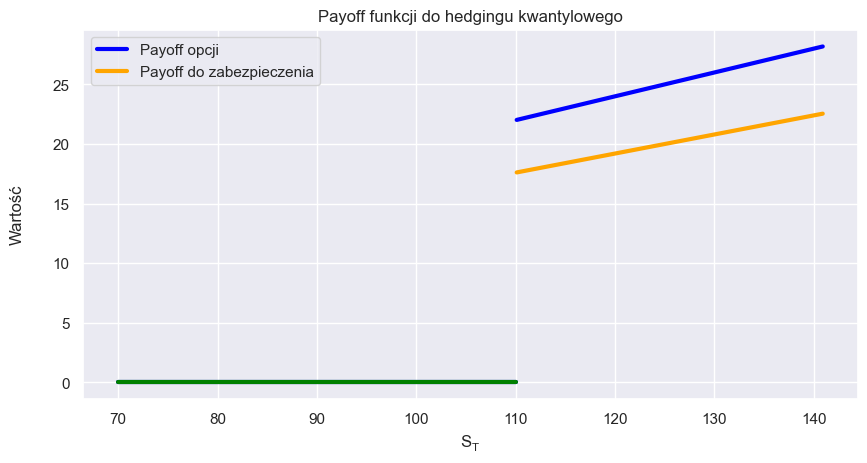

In [106]:
ST = np.arange(70,141,0.1)
X = np.zeros(shape=(len(ST),2))
X[:,0], X[:,1] = X0, ST
X = pd.DataFrame(X)

fig = plt.figure()
fig.set_figwidth(10)
plt.plot(ST[ST<=K],np.array(measure_payoff(X.iloc[ST<=K,:],p,K)), color = 'blue', linewidth = 3, label='Payoff opcji')
plt.plot(ST[ST>K],np.array(measure_payoff(X.iloc[ST>K,:],p,K)), color = 'blue', linewidth = 3)
plt.plot(ST[ST<=K],np.array(measure_payoff(X.iloc[ST<=K,:],p,K)), color = 'green', linewidth = 3)
plt.plot(ST[ST>K],0.8*np.array(measure_payoff(X.iloc[ST>K,:],p,K)), color = 'orange', linewidth = 3, label='Payoff do zabezpieczenia')
plt.xlabel('$\mathregular{S_T}$')
plt.ylabel('Wartość', labelpad=20)
plt.title('Payoff funkcji do hedgingu kwantylowego')
plt.legend(loc="upper left")

Mają już wyprowadzoną całą teorię, możemy spojrzeć jak rpzekłąda się ona na wyniki z symulacji. Zobaczmy więc, jak zwiększanie przekazywanego na hedging  kwantylowy kapitału, przekłada się, na funkcje celu w przypadku procentowej opcji call.

Uwaga 1: Do poniższych symulacji oraz oszacowania ceny opcji korzystamy z symulacji Monte Carlo (jest to przy okazji test, czy nasza klasa działa na "dowoloną" opcję), jednak można by użyć jawnych wzorów, ponieważ w przypadku powyższej opcji wszystkie wartości są nam znane, gdyż ich wyprowadzenie jest niemalże identyczne jak w przypadku klasycznej opcji call. Tak więc dla zainteresowanych:

Cena Procentowej Opcji Call:

$$H_{t} = (1-p) \cdot S_{0} \cdot \Phi(d_{2} + \sigma \cdot \sqrt{T-t},0,1),$$

gdzie $\Phi(x,0,1)$ oznacza dystrybuantę rozkładu normalnego N(0,1), natomiast

$$d_{2} = \frac{log{\left( \frac{S_{0}}{K} \right) + \left( r - \frac{\sigma^{2}}{2} \right) \cdot \left( T-t \right)}}{\sigma \cdot \sqrt{T-t} },$$

Wzór na Deltę:
$$\Delta_{t} = (1-p) \cdot \Phi(d_{2},0,1).$$

Uwaga 2: przyjęliśmy bardzo rygorystyczny warunek, że wyniki poniżej zera są porażkami (tak więc delta hedging dajacy przykładowo -0.05 jest wartością ujemną, a więc porażką, a nie "blisko zera = sukcesem"

Spójrzmy na wyniki symulacji:

In [59]:
alphas = np.arange(0.15,1,0.2)
repeat = 1000

mu = 0.06
sigma =  0.2
r = 0.03
T = 1
X0 = 100
repeat = 20
values_per_year = 250
K = 110

def measure_payoff(X,p,K):
    return (1-p)*X.iloc[:, -1]*(X.iloc[:, -1] > K)

underlying = Underlying(mu, sigma, r, values_per_year)
_, reality = underlying.simulate_P(repeat, T)
option = Option(underlying,lambda X : measure_payoff(X,p,K),T)
Measure_Price = option.get_MC_price(X0)

Collection_Funkcja_Uno_Mean = []
Collection_Funkcja_Dos_Mean = []

for a in alphas:
    funkcja_uno = np.zeros(reality.shape[0])
    funkcja_dos = np.zeros(reality.shape[0])
    for i in tqdm(range(repeat)):
        trader = Trader(initial_capital = a*Measure_Price)
        dont_mind, don_care, obj = trader.simulate_hedging(option, X0*reality.iloc[[i],:], update_freq = 1)
        funkcja_uno[i] = obj[0]
        funkcja_dos[i] = obj[1]
    Collection_Funkcja_Uno_Mean.append(np.mean(funkcja_uno))
    Collection_Funkcja_Dos_Mean.append(np.mean(funkcja_dos))

100%|██████████| 20/20 [01:56<00:00,  5.84s/it]


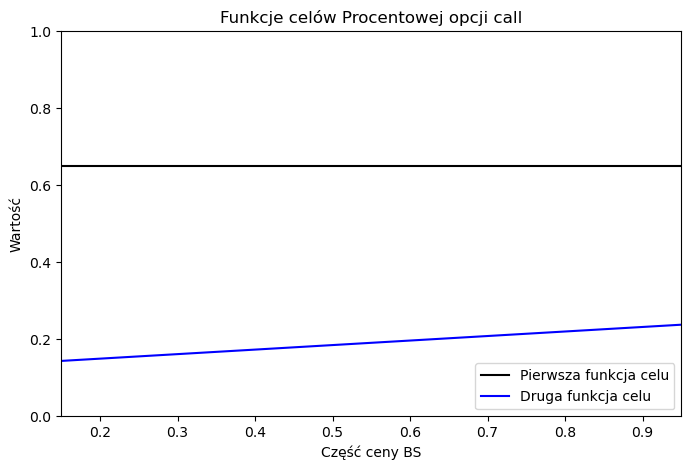

In [60]:
fig = plt.figure()
fig.set_figwidth(8,5)
fig.set_figheight(5)
plt.plot(alphas, Collection_Funkcja_Uno_Mean, color = 'black')
plt.plot(alphas, Collection_Funkcja_Dos_Mean, color = 'blue')
plt.legend(['Pierwsza funkcja celu', 'Druga funkcja celu'], loc = 'lower right')
plt.title('Funkcje celów Procentowej opcji call')
plt.xlabel('Część ceny BS')
plt.ylabel('Wartość')
plt.xlim([min(alphas),max(alphas)])
plt.ylim([0,1])
plt.show()

Możemy ogłosić sukces! Jak widzimy, dla opcji zaprojektowanej w ten sposób, zwiększanie nakładów na hedging kwantylowy rzeczywiście optymalizuje drugą funkcję celu, mimo że nie zmienia nic w wartośći pierwszej. Udało się nam więc jawnie uwypuklić, że teoria stojąca za optymalizowaniem drugiej funkcji celu działa samoistnie i nie jest implikowana przez optymalizację pierwszej funkcji celu